## Copied from Ted_2

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import unidecode
%matplotlib inline
import copy
from nltk.corpus import stopwords
from nltk import sent_tokenize

In [2]:
import scipy.stats as ss

In [3]:
import requests
from pattern import web

##Read in the caption data 

In [4]:
capdata = pd.read_csv('tedcaption.csv',encoding = 'utf-8',index_col = ['id','index'])

In [5]:
capdata.head()

content  duration  \
id index                                                                
1  0      Thank you so much, Chris. And it's truly a gre...      4000   
   1      to have the opportunity to come to this stage ...      4000   
   2      I have been blown away by this conference, and...      7000   
   3      nice comments about what I had to say the othe...      5000   
   4      And I say that sincerely, partly because -- (M...     12000   

         startOfParagraph  startTime  
id index                              
1  0                 True       3000  
   1                False       7000  
   2                False      11000  
   3                False      18000  
   4                False      23000

In [6]:
capdata.shape

(525171, 4)

###Read in capstat 

In [41]:
capstat = pd.read_json('captalks_f.json')[['id','length','num_para','wordcounts','word_per_sec']]

In [42]:
capstat.shape

(1885, 5)

##2. Combine with Ted_4 to mining features from the transcripts

In [16]:
testresponse = pd.read_csv('test_response.csv',header = None)

In [17]:
testresponse.columns = ['id','label']

### select captions from talks in the final training set 

In [18]:
ids = list(testresponse['id'])

In [19]:
captions = capdata[capdata.index.get_level_values('id').isin(ids)]

In [20]:
len(captions.index.get_level_values('id').unique())

350

In [21]:
corpus = []
for idx in ids:
    text = []
    for index,row in captions[captions.index.get_level_values('id')==idx].iterrows():
        text.append(row['content'])
    corpus.append(text)

In [22]:
len(corpus)

350

In [24]:
captions_test_f = pd.DataFrame(dict(id = ids, text = corpus))

In [25]:
captions_test_f.head(1)

,id,text
0,1146,"[Think about your day for a second., You woke ..."


In [26]:
captions_test_f.shape

(350, 2)

###2.1 Find how many "(Laughter)" and "(Applause)" 

####2.1.1Total number of laughter

In [27]:
import re

In [29]:
len(re.findall(r'(Laughter)',captions_test_f.text[0][4]))

0

In [31]:
def findalllaughter(text):
    content = ';'.join(text)
    num = len(re.findall(r'(Laughter)',content))
    return num

In [33]:
findalllaughter(captions_test_f.text[0])

1

In [34]:
laughter_total = captions_test_f.text.apply(findalllaughter)

In [35]:
captions_test_f['laughter_total'] = laughter_total

In [37]:
captions_test_f.head()

,id,text,laughter_total
0,1146,"[Think about your day for a second., You woke ...",1
1,1153,"[I want to share with you, over the next 18 mi...",0
2,1154,"[The story I wanted to share with you today, i...",0
3,223,[Dan Holzman: Please throw out the beanbag cha...,37
4,103,[I'm not quite sure whether I really want to s...,1


In [38]:
captions_test_f.shape

(350, 3)

In [43]:
temp = capstat[capstat['id'].isin(ids)]

In [44]:
temp.shape

(350, 5)

In [46]:
captions_test_f = pd.merge(captions_test_f, temp, on = 'id')

In [51]:
captions_test_f.head()

,id,text,laughter_total,length,num_para,wordcounts,word_per_sec,laughter_per_word,para_length
0,1146,"[Think about your day for a second., You woke ...",1,1080,35,3893,3.604630,0.000257,111.228571
1,1153,"[I want to share with you, over the next 18 mi...",0,1367,36,3670,2.684711,0.000000,101.944444
2,1154,"[The story I wanted to share with you today, i...",0,615,12,1410,2.292683,0.000000,117.500000
3,223,[Dan Holzman: Please throw out the beanbag cha...,37,908,185,1831,2.016520,0.020208,9.897297
4,103,[I'm not quite sure whether I really want to s...,1,1613,28,3244,2.011159,0.000308,115.857143


In [48]:
captions_test_f['laughter_per_word'] = captions_test_f['laughter_total']/captions_test_f.wordcounts

In [49]:
captions_test_f['word_per_sec'] = captions_test_f['wordcounts']/captions_test_f.length

In [50]:
captions_test_f['para_length'] = captions_test_f['wordcounts']/captions_test_f['num_para']

####2.1.2 How many applause 

In [52]:
def findallapplause(text):
    content = ';'.join(text)
    num = len(re.findall(r'(Applause)',content))
    return num

In [53]:
applause_total = captions_test_f.text.apply(findallapplause)

In [55]:
captions_test_f.columns

Index([               u'id',              u'text',    u'laughter_total',
                  u'length',          u'num_para',        u'wordcounts',
            u'word_per_sec', u'laughter_per_word',       u'para_length'],
      dtype='object')

In [56]:
captions_test_f['applause_total']= applause_total

In [58]:
captions_test_f.applause_total.describe()

count    350.000000
mean       2.128571
std        2.190900
min        0.000000
25%        1.000000
50%        1.000000
75%        3.000000
max       18.000000
Name: applause_total, dtype: float64

In [59]:
captions_test_f['applause_per_word']= captions_test_f['applause_total']/captions_test_f['wordcounts']

#### 2.1.3 How many "So" and "And so", "I think" "I don't think" , "--"

In [60]:
def countallso(text):
    content = ';'.join(text)
    num = len(re.findall(r'And so',content))
    return num

In [61]:
countso = captions_test_f.text.apply(countallso)

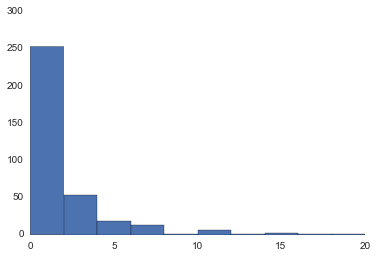

In [62]:
countso.hist()

In [63]:
captions_test_f['And_so_total'] = countso

In [65]:
captions_test_f.columns

Index([               u'id',              u'text',    u'laughter_total',
                  u'length',          u'num_para',        u'wordcounts',
            u'word_per_sec', u'laughter_per_word',       u'para_length',
          u'applause_total', u'applause_per_word',      u'And_so_total'],
      dtype='object')

#### So seems to be not predictive after a few trial, move on to "--", which often stands for interjections in the transcripts

In [68]:
# define a fun to find '--' and '-'
def finddiv(text):
    content = ';'.join(text)
    num = len(re.findall(r'--',content))
    return num

In [69]:
diversion = captions_test_f.text.apply(finddiv)

In [70]:
captions_test_f['diversion'] = diversion

### merge the response into captions_f 

In [71]:
captions_test_f = captions_test_f.merge(testresponse, on = 'id')

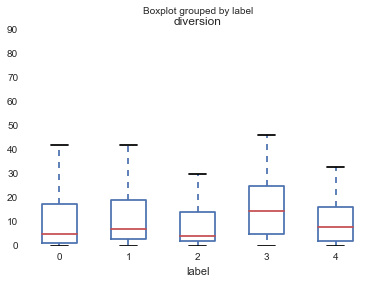

In [72]:
captions_test_f.boxplot(column = 'diversion', by = 'label')

In [73]:
div_per_word = captions_test_f.diversion/captions_test_f.wordcounts

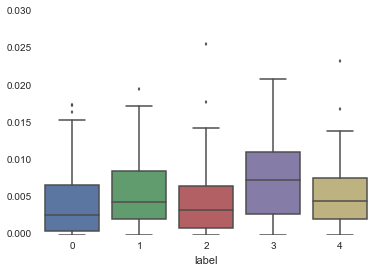

In [74]:
sns.boxplot(div_per_word,groupby = captions_test_f.label)

In [75]:
captions_test_f['div_per_word'] = div_per_word

In [76]:
div_per_word_labeled = [col for colname,col in captions_test_f.groupby('label')['div_per_word']]

In [77]:
f_val, p_val = ss.f_oneway(*div_per_word_labeled)
print 'p value is:{}'.format(p_val)

p value is:0.00400394403154


#### How about "I (don't) think" "my ** journey" 

In [78]:
def findthink(text):
    content = ';'.join(text)
    num = len(re.findall(r'I\s*[\w\']*\s*think',content))
    return num

In [79]:
ithinks = captions_test_f.text.apply(findthink)

In [80]:
ithinks.describe()

count    350.000000
mean       2.780000
std        3.813736
min        0.000000
25%        0.000000
50%        1.000000
75%        4.000000
max       29.000000
Name: text, dtype: float64

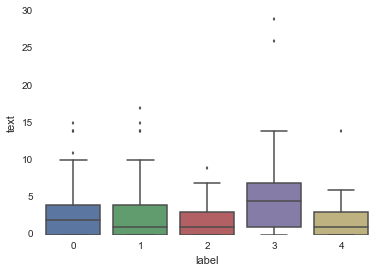

In [81]:
sns.boxplot(ithinks, groupby=captions_test_f.label)

In [82]:
captions_test_f['ithinks'] = ithinks

In [83]:
ithinks_labeled = [col for colname,col in captions_test_f.groupby('label')['ithinks']]

In [84]:
f_val, p_val = ss.f_oneway(*ithinks_labeled)
print 'p value is:{}'.format(p_val)

p value is:2.3134413912e-06


In [85]:
# (my) journey
def findstory(text):
    content = ';'.join(text)
    story_words = '|'.join(['journey','story','experience'])
    num = len(re.findall(story_words,content))
    return num

In [86]:
storywords = captions_test_f.text.apply(findstory)

In [87]:
storywords.describe()

count    350.000000
mean       2.931429
std        4.120100
min        0.000000
25%        0.000000
50%        1.000000
75%        4.000000
max       28.000000
Name: text, dtype: float64

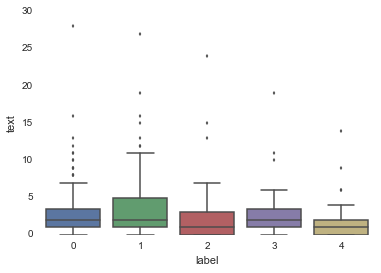

In [88]:
sns.boxplot(storywords, groupby=captions_test_f.label)

In [89]:
captions_test_f['storywords']=storywords

###2.2 Laughter or Applause as standalone paragraph 

In [90]:
def laughpara(text):
    counts = 0
    for paras in text:
        laugh = paras == '(Laughter)'
        counts += laugh
    return counts

In [91]:
laughpara = captions_test_f.text.apply(laughpara)

In [92]:
def applausepara(text):
    counts = 0
    for paras in text:
        laugh = paras == '(Applause)'
        counts += laugh
    return counts

In [93]:
applausepara = captions_test_f.text.apply(applausepara)

In [94]:
captions_test_f['app_as_para'] = applausepara
captions_test_f['laugh_as_para'] = laughpara

In [95]:
captions_test_f.columns

Index([               u'id',              u'text',    u'laughter_total',
                  u'length',          u'num_para',        u'wordcounts',
            u'word_per_sec', u'laughter_per_word',       u'para_length',
          u'applause_total', u'applause_per_word',      u'And_so_total',
               u'diversion',             u'label',      u'div_per_word',
                 u'ithinks',        u'storywords',       u'app_as_para',
           u'laugh_as_para'],
      dtype='object')

In [96]:
captions_test_f.head()

,id,text,laughter_total,length,num_para,wordcounts,word_per_sec,laughter_per_word,para_length,applause_total,applause_per_word,And_so_total,diversion,label,div_per_word,ithinks,storywords,app_as_para,laugh_as_para
0,1146,"[Think about your day for a second., You woke ...",1,1080,35,3893,3.604630,0.000257,111.228571,2,0.000514,5,30,2,0.007706,2,5,2,1
1,1153,"[I want to share with you, over the next 18 mi...",0,1367,36,3670,2.684711,0.000000,101.944444,3,0.000817,1,32,1,0.008719,0,6,3,0
2,1154,"[The story I wanted to share with you today, i...",0,615,12,1410,2.292683,0.000000,117.500000,1,0.000709,0,14,1,0.009929,0,10,1,0
3,223,[Dan Holzman: Please throw out the beanbag cha...,37,908,185,1831,2.016520,0.020208,9.897297,11,0.006008,1,4,4,0.002185,5,0,8,23
4,103,[I'm not quite sure whether I really want to s...,1,1613,28,3244,2.011159,0.000308,115.857143,6,0.001850,10,42,2,0.012947,6,24,2,0


In [97]:
captions_test_f['funny_binary']= captions_test_f.label == 4
captions_test_f['neg_binary'] = captions_test_f.label == 3

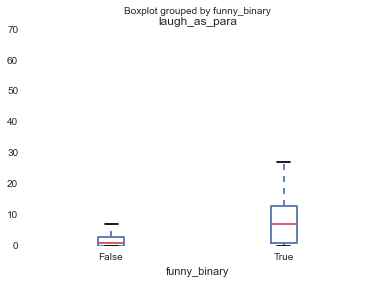

In [98]:
captions_test_f.boxplot(column='laugh_as_para',by = 'funny_binary',)

In [99]:
captions_test_f['app_total_log'] = captions_test_f['applause_total'].apply(lambda x: np.log10(x))

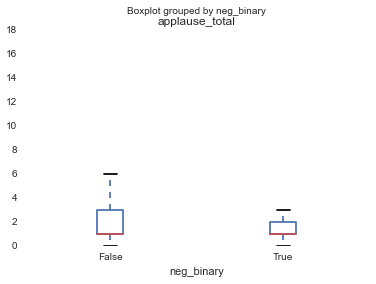

In [100]:
captions_test_f.boxplot(column='applause_total',by = 'neg_binary',)

In [101]:
captions_test_f.columns

Index([               u'id',              u'text',    u'laughter_total',
                  u'length',          u'num_para',        u'wordcounts',
            u'word_per_sec', u'laughter_per_word',       u'para_length',
          u'applause_total', u'applause_per_word',      u'And_so_total',
               u'diversion',             u'label',      u'div_per_word',
                 u'ithinks',        u'storywords',       u'app_as_para',
           u'laugh_as_para',      u'funny_binary',        u'neg_binary',
           u'app_total_log'],
      dtype='object')

In [102]:
captions_test_f[captions_test_f.neg_binary==True].app_as_para.describe()

count    36.000000
mean      1.083333
std       0.906327
min       0.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       4.000000
Name: app_as_para, dtype: float64

In [103]:
captions_test_f[captions_test_f.neg_binary==False].app_as_para.describe()

count    314.000000
mean       1.757962
std        1.788859
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       13.000000
Name: app_as_para, dtype: float64

###Save captions_f 

In [104]:
captions_test_f.columns

Index([               u'id',              u'text',    u'laughter_total',
                  u'length',          u'num_para',        u'wordcounts',
            u'word_per_sec', u'laughter_per_word',       u'para_length',
          u'applause_total', u'applause_per_word',      u'And_so_total',
               u'diversion',             u'label',      u'div_per_word',
                 u'ithinks',        u'storywords',       u'app_as_para',
           u'laugh_as_para',      u'funny_binary',        u'neg_binary',
           u'app_total_log'],
      dtype='object')

In [105]:
captions_test_f.to_json('captions_test_f.json')

###2.3 Mining transcripts with spaCy and NLTK 

In [106]:
from __future__ import unicode_literals
from spacy.en import English, attrs
from spacy import en
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

In [107]:
from spacy.parts_of_speech import ADV, NOUN, ADJ, PUNCT, VERB

In [108]:
# remove punctuations
from string import punctuation

In [109]:
nlp = English()

In [111]:
captions_test_f.sort(columns = 'id',inplace = True)

In [112]:
captions_test_f.reset_index(inplace = True, drop = True)

In [113]:
captions_test_f.shape

(350, 22)

### combine all paragraphs 

In [114]:
punset = set(punctuation)

In [115]:
stopset = set(stopwords.words('english'))

to keep it's that's etc unseparated, do this
test3 = re.sub('\'','\u2019',test2)

###2.3.1 Tokenize the text, lower the case, remove punctuations and interjections (laughter, mob, applause)

In [116]:
def tokenize(text):
    # return word tokens
    # text comes in as list of paragraph
    text = ' '.join(text)
    # remove '(Laughter)' etc, 
    text = re.sub('\([\w\s]+\)','',text)
    text = text.lower()
    tokens = nlp(text, parse = False)
    words = []
    for token in tokens:
        # remove punctuations
        if token.pos != PUNCT:
            words.append(token)
    return words

###2.3.2 Count stopwords 

In [117]:
def stopcounts(token_list):
    # token_list comes in as a list
    num_words = len(token_list)
    count = 0
    for token in token_list:
        if token.string.strip(' ').lower() in stopset:
            count += 1
    return count/float(num_words)

In [118]:
tokens = captions_test_f.text.apply(tokenize)

In [119]:
tokens.shape

(350,)

In [120]:
captions_test_f['cap_tokens'] = tokens

In [121]:
stopwords_ratio = captions_test_f['cap_tokens'].apply(stopcounts)

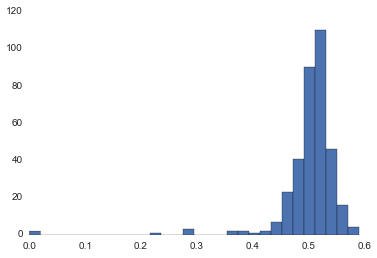

In [122]:
stopwords_ratio.hist(bins = 30)

In [123]:
captions_test_f['stopwords_ratio'] = stopwords_ratio

In [124]:
captions_test_f.columns

Index([               u'id',              u'text',    u'laughter_total',
                  u'length',          u'num_para',        u'wordcounts',
            u'word_per_sec', u'laughter_per_word',       u'para_length',
          u'applause_total', u'applause_per_word',      u'And_so_total',
               u'diversion',             u'label',      u'div_per_word',
                 u'ithinks',        u'storywords',       u'app_as_para',
           u'laugh_as_para',      u'funny_binary',        u'neg_binary',
           u'app_total_log',        u'cap_tokens',   u'stopwords_ratio'],
      dtype='object')

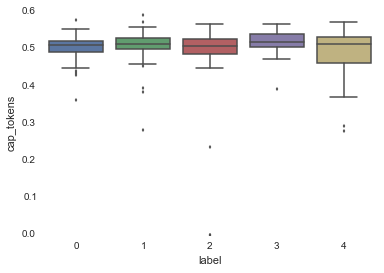

In [125]:
sns.boxplot(stopwords_ratio,groupby = captions_test_f.label)

In [127]:
stopwords_labeled = [col for colname,col in captions_test_f.groupby('label')['stopwords_ratio']]

In [128]:
f_val, p_val = ss.f_oneway(*stopwords_labeled)
print 'p value is:{}'.format(p_val)

p value is:0.058380029566


####So there is no evident difference  

### 2.3.2 Count important POS, take label class 2 (jaw-dropping) and 0 (informative) for example 

In [129]:
# define a function to take cap_tokens as input and output list of unique tokens 
# joined as a string for CountVectorizer 
def getpos(token_list,prob = -10,pos = ADJ):
    words = []
    for token in token_list:
        if token.pos == pos and token.prob < prob:
            words.append(token.lemma_)
            words = list(set(words))
    return words

In [130]:
captions_test_f['noun_token'] = captions_test_f.cap_tokens.apply(getpos,pos = NOUN, prob = -3).apply(lambda x: ' '.join(x))

In [131]:
captions_test_f['verb_token'] = captions_test_f.cap_tokens.apply(getpos,pos = VERB, prob = -3).apply(lambda x: ' '.join(x))

In [132]:
captions_test_f.drop('cap_tokens',axis = 1,inplace = True)

In [133]:
captions_test_f.columns

Index([               u'id',              u'text',    u'laughter_total',
                  u'length',          u'num_para',        u'wordcounts',
            u'word_per_sec', u'laughter_per_word',       u'para_length',
          u'applause_total', u'applause_per_word',      u'And_so_total',
               u'diversion',             u'label',      u'div_per_word',
                 u'ithinks',        u'storywords',       u'app_as_para',
           u'laugh_as_para',      u'funny_binary',        u'neg_binary',
           u'app_total_log',   u'stopwords_ratio',        u'noun_token',
              u'verb_token'],
      dtype='object')

In [134]:
captions_test_f.to_json('captions_test_f.json')